# Homework 3

## Task 1
**Submitted by: Soumik Ghosh**

In [1]:
import pandas as pd

First, download a simulated dataset: kmeans_data.zip from Modules->Datasets. Then, 
implement the K-means algorithm from scratch. K-means algorithm computes the distance of a 
given data point pair. Replace the distance computation function with Euclidean distance, 1- 
Cosine similarity, and 1 – the Generalized Jarcard similarity (refer to: 
https://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/jaccard.htm). 

In [2]:
X = pd.read_csv("./kmeans_data/data.csv")
Y = pd.read_csv("./kmeans_data/label.csv")


In [3]:
X

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
Y

,7
0,2
1,1
2,0
3,4
4,1
...,...
9994,2
9995,3
9996,4
9997,5


The K-Means Algorithm from scratch along with Euclidean distance, Cosine similarity, and the Generalized Jaccard similarity. 

```py
import concurrent.futures
import numpy as np
import pandas as pd
import time


def lists_equal(a, b):
    return np.array_equal(np.sort(a), np.sort(b))

#distance computation function with Euclidean distance
def euclidean(a, b):
    return np.sqrt(np.sum(np.square(np.subtract(a, b))))

#distance computation function with cosine similarity
def cosine(a, b):
    return 1 - np.divide(np.sum(np.multiply(a, b)),
                         np.multiply(np.sqrt(np.sum(np.square(a))),
                                     np.sqrt(np.sum(np.square(b)))))

#distance computation function with jaccard distance
def jaccard(a, b):
    return 1 - np.divide(np.sum(np.minimum(a, b)),
                         np.sum(np.maximum(a, b)))


def SSE(distance_function, X, centroids):
    result = 0
    for centroid in centroids:
        for point in X:
            result += distance_function(centroid, point)**2
    return result


def accuracy(Y, computed_Y):
    cluster_score = []
    for i in range(len(Y)):
        cluster_score.insert(i, [])
        for j in range(len(Y)):
            cluster_score[i].insert(j, 0)
    
    for i in range(len(Y)):
        cluster_score[computed_Y[i]][Y[i][0]] += 1
    
    correct = 0
    total = 0
    for i in range(len(Y)):
        winner = 0
        max_seen = 0
        for j in range(len(Y)):
            if cluster_score[i][j] > max_seen:
                winner = j
                max_seen = cluster_score[i][j]
                
        for j in range(len(Y)):
            total += cluster_score[i][j]
            if j == winner:
                correct += cluster_score[i][j]
    return correct / total


def Kmeans(distance_func, X, Y=[], K=0, centroids=np.array([]), stoppers=["Centroid unchanged"],
           maxIterations=0, task_id=""):

    if task_id == "stopper":
        ret = str(distance_func.__name__) + "\t" + str(stoppers) + "\n"
    else:
        ret = str(distance_func.__name__) + "\n"
   
    computed_Y = np.full(X.shape[0], 0)
   
    if len(stoppers) < 1 and maxIterations == 0:
        print("Missing stop criteria.")
        return
  
    if centroids.size > 0:

        if len(centroids) != K:
            print("Mismatch Found " + str(centroids) +
                  "Initial centroids with K = " + str(K))
 
    else:
        centroids = X[np.random.choice(X.shape[0], K, replace=False), :]

    start = time.time_ns()
    iterations = 0
    while True:

        old_centroids = np.copy(centroids)
        iterations += 1

        tmp_centroid_sum = np.zeros(centroids.shape)
        tmp_centroid_count = np.zeros(centroids.shape[0])
    
        for point_idx, point in enumerate(X):
            shortest_distance = float('inf')
  
            for centroid_idx, centroid in enumerate(centroids):
                distance = distance_func(point, centroid)
                if distance < shortest_distance:
                    shortest_distance = distance

                    computed_Y[point_idx] = centroid_idx

            tmp_centroid_sum[computed_Y[point_idx]] = np.add(
                tmp_centroid_sum[computed_Y[point_idx]], point)

            tmp_centroid_count[computed_Y[point_idx]] += 1

        for i in range(len(centroids)):

            if tmp_centroid_count[i] == 0:
                print("A centroid was found empty at iteration " + str(iterations))

                centroids[i] = np.copy(old_centroids[i])
            else:

                centroids[i] = np.divide(tmp_centroid_sum[i],
                                         np.full(centroids.shape[1], tmp_centroid_count[i]))

        if "Centroid unchanged" in stoppers and lists_equal(old_centroids, centroids):
            break #when there is no change in centroid position
           
        if "SSE" in stoppers and SSE(distance_func, X, centroids) \
                > SSE(distance_func, X, old_centroids):

            centroids = np.copy(old_centroids)
            break #when the SSE value increases in the next iteration

        if (maxIterations != 0 and iterations >= maxIterations) \
                or (maxIterations == 0 and iterations >= 500):
            break #when the maximum preset value (e.g., 500, here) of iteration is complete

    end = time.time_ns()

    if task_id == "task1":
        ret += "SSE = " + str(SSE(distance_func, X, centroids)) + "\n"
        ret += "Predictive accuracy = " + str(accuracy(Y, computed_Y))
    if task_id == "stopper":
        ret += str(iterations) + "\t" + str(SSE(distance_func, X, centroids)) \
            + "\t" + str(end - start) + " nsec"
    return ret


def main():

    X = pd.read_csv("./Kmeans_data/data.csv")
    Y = pd.read_csv("./Kmeans_data/label.csv")
    X = X.to_numpy(dtype=float)
    Y = Y.to_numpy(dtype=int)

  
    with concurrent.futures.ProcessPoolExecutor(max_workers=24) as executor:
        
        futures = []

        #Task 1.1 and 1.2
        futures.append(executor.submit(
            Kmeans, euclidean, X, Y=Y, K=10, task_id="task1"))
        futures.append(executor.submit(
            Kmeans, cosine, X, Y=Y, K=10, task_id="task1"))
        futures.append(executor.submit(
            Kmeans, jaccard, X, Y=Y, K=10, task_id="task1"))

        #Task 1.3
        futures.append(executor.submit(Kmeans, euclidean, X, Y=Y,
                       K=10, maxIterations=500, stoppers=["Centroid unchanged", "SSE"], task_id="stopper"))
        futures.append(executor.submit(Kmeans, cosine, X, Y=Y,
                       K=10, maxIterations=500, stoppers=["Centroid unchanged", "SSE"], task_id="stopper"))
        futures.append(executor.submit(Kmeans, jaccard, X, Y=Y,
                       K=10, maxIterations=500, stoppers=["Centroid unchanged", "SSE"], task_id="stopper"))

        #Task 1.4
        futures.append(executor.submit(Kmeans, euclidean, X, Y=Y,
                       K=10, stoppers=["Centroid unchanged"], task_id="stopper"))
        futures.append(executor.submit(Kmeans, cosine, X, Y=Y,
                       K=10, stoppers=["Centroid unchanged"], task_id="stopper"))
        futures.append(executor.submit(Kmeans, jaccard, X, Y=Y,
                       K=10, stoppers=["Centroid unchanged"], task_id="stopper"))

        futures.append(executor.submit(Kmeans, euclidean, X, Y=Y,
                       K=10, stoppers=["SSE"], task_id="stopper"))
        futures.append(executor.submit(Kmeans, cosine, X, Y=Y,
                       K=10, stoppers=["SSE"], task_id="stopper"))
        futures.append(executor.submit(Kmeans, jaccard, X, Y=Y,
                       K=10, stoppers=["SSE"], task_id="stopper"))

        futures.append(executor.submit(Kmeans, euclidean, X, Y=Y,
                       K=10, stoppers=[], maxIterations=100, task_id="stopper"))
        futures.append(executor.submit(Kmeans, cosine, X, Y=Y,
                       K=10, stoppers=[], maxIterations=100, task_id="stopper"))
        futures.append(executor.submit(Kmeans, jaccard, X, Y=Y,
                       K=10, stoppers=[], maxIterations=100, task_id="stopper"))

        
        iter_futures = iter(futures)

        print("Task 1.1 and Task 1.2")
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())

        print("Task 1.3")
        print("Iterations\tSSE\tTime")
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())

        print("Task 1.4")
        print("Iterations\tSSE\tTime")
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())
        print(next(iter_futures).result())

if __name__ == "__main__":
    main()



```

In [5]:
%run kmeans.py

Task 1.1 and Task 1.2
euclidean
SSE = 436369212652.1854
Predictive accuracy = 0.5457545754575458
cosine
SSE = 23220.398994073825
Predictive accuracy = 0.613961396139614
jaccard
SSE = 55504.82026141716
Predictive accuracy = 0.6026602660266026
Task 1.3
Iterations	SSE	Time
euclidean	['Centroid unchanged', 'SSE']
2	427847139709.5715	11966323000 nsec
cosine	['Centroid unchanged', 'SSE']
2	21166.13206031724	26862744000 nsec
jaccard	['Centroid unchanged', 'SSE']
2	54770.26162150278	19033837000 nsec
Task 1.4
Iterations	SSE	Time
euclidean	['Centroid unchanged']
132	436185049037.8496	169388425000 nsec
cosine	['Centroid unchanged']
98	23250.246340270107	271966014000 nsec
jaccard	['Centroid unchanged']
127	55554.143461042986	241112379000 nsec
euclidean	['SSE']
2	416463829644.0569	12136429000 nsec
cosine	['SSE']
2	20555.7750454883	26936057000 nsec
jaccard	['SSE']
2	55075.81823631333	19263255000 nsec
euclidean	[]
100	439657131278.5757	135249331000 nsec
cosine	[]
100	22993.938266168097	277426944000 n

## Task 2

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from IPython.display import Image
init_notebook_mode(connected=True)
%matplotlib inline

import surprise
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV
from surprise import Reader
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans



### a. Read the data from "ratings_small.csv".

In [2]:
rating_df = pd.read_csv("./movies_data/ratings_small.csv")
rating_df.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


We load the data ino surprise specific data-structure.

In [3]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_df[['userId', 'movieId', 'rating']], reader)

### b. Mean Absolute Error and Root Mean Square Error
$$
\begin{align}
  \tag{1.1}
  MAE = \frac{\sum_{i=1}^{n} \lvert y_{i} - x_{i} \rvert}{n} = \frac{\sum_{i=1}^{n}\lvert e_{i} \rvert}{n}
\end{align}
$$
$$
\begin{align}
  \tag{1.2}
  RMSE = \sqrt{\frac{\sum_{i=1}^{n} (\hat{y_{i}} - y_{i})^2}{n}}
\end{align}
$$



### c. Let us compute the average MAE and RMSE of Probabilistic Matrix Factorization (PMF), User-based Collaborative Filtering, Item-based Collaborative Filtering, under 5-fold croos validation.

In [15]:

comparison = []
#{'user_based': False} for item-based
for algorithm in [SVD(biased=False), KNNBasic(sim_options = {'user_based': True }), KNNBasic(sim_options = {'user_based': False})]:
    #5-folds cross-validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    
    temp = pd.DataFrame.from_dict(results).mean(axis=0)
    pd.concat([temp, (pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))])

    comparison.append(temp)




Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0018  1.0192  1.0095  1.0061  1.0015  1.0076  0.0065  
MAE (testset)     0.7715  0.7834  0.7793  0.7788  0.7740  0.7774  0.0042  
Fit time          0.40    0.41    0.41    0.39    0.39    0.40    0.01    
Test time         0.06    0.06    0.06    0.14    0.06    0.07    0.03    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9733  0.9660  0.9625  0.9684  0.9671  0.9674  0.0035

### d. Let us compare the average (mean) performances of User-based collaborative filtering, item-based collaborative filtering, PMF with respect to RMSE and MAE. 

In [17]:
comparison = pd.DataFrame(comparison)
algorithms1 = ['PMF','User-basedCF','Item-basedCF']
comparison['Algorithm'] = algorithms1
comparison


,test_rmse,test_mae,fit_time,test_time,Algorithm
0,1.007623,0.777414,0.398352,0.074804,PMF
1,0.967446,0.743892,0.040319,0.722284,UserCF
2,0.934863,0.720896,1.546842,3.134647,ItemCF


Comparing, we can see here that the ItemCF has the lowest RMSE and MAE. So, Item-based Collaborative filtering is the best model.

### e. Examining the cosine, MSD (Mean Squared Difference), and Pearson similarities impact the performances of User based Collaborative Filtering and Item based Collaborative Filtering. 

In [20]:
benchmark_sim = []

#{'user_based': False} for item-based
for algorithm in [  KNNBasic(sim_options = {'name':'cosine','user_based': True}), 
                    KNNBasic(sim_options = {'name':'MSD', 'user_based':True }),
                    KNNBasic(sim_options = {'name':'pearson','user_based': True}),
                    KNNBasic(sim_options = {'name':'cosine', 'user_based':False }),
                    KNNBasic(sim_options = {'name':'MSD', 'user_based':False }),
                    KNNBasic(sim_options = {'name':'pearson','user_based': False}) 
                 ]:
    #5-folds cross-validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    
    temp = pd.DataFrame.from_dict(results).mean(axis=0)
    pd.concat([temp, (pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))])
    
    benchmark_sim.append(temp)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson si

In [36]:
benchmark_sim = pd.DataFrame(benchmark_sim)
algorithms2 = ['Cosine_User-basedCF','MSD_User-basedCF','Pearson_User-basedCF','Cosine_Item-basedCF','MSD_Item-basedCF','Pearson_Item-basedCF']
benchmark_sim['Algorithm'] = algorithms2

comparison_sim = benchmark_sim.set_index('Algorithm').sort_values('Algorithm', ascending=False)
comparison_sim

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
Pearson_User-basedCF,0.996754,0.772140,0.086357,0.760286
Pearson_Item-basedCF,0.988930,0.767769,5.954332,3.052409
MSD_User-basedCF,0.967708,0.743974,0.042340,0.764820
MSD_Item-basedCF,0.934963,0.720677,1.711636,3.206948
Cosine_User-basedCF,0.993580,0.767566,0.064752,0.799561
Cosine_Item-basedCF,0.994450,0.774229,3.417526,3.071391


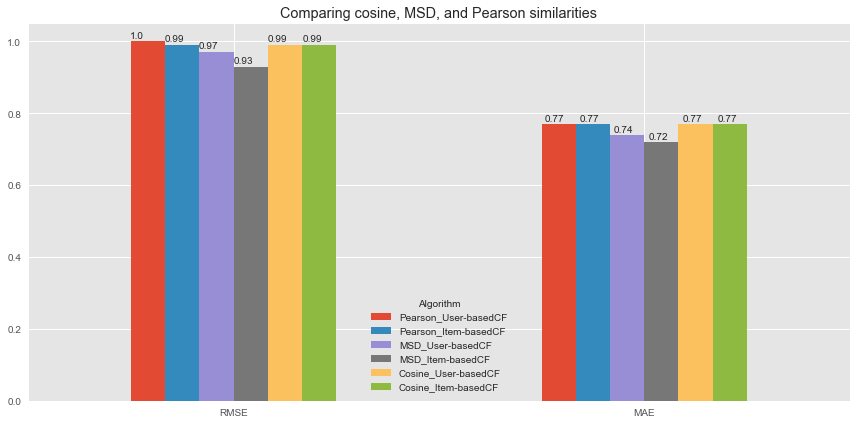

In [59]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
ax= comparison_sim[['test_rmse','test_mae']].rename(columns={'test_rmse':'RMSE', 'test_mae':'MAE'}).T.round(2).plot(kind='bar', figsize=(12, 6))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.01))
plt.title('Comparing cosine, MSD, and Pearson similarities')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### f. Examining how the number of neighbors impacts the performances of User-based Collaborative Filtering and Item-based Collaborative Filtering?